In [1]:
import time
import os
import subprocess
import sys
sys.path.insert(0,'..')
import re
import argparse
import collections
import gzip
import math
import shutil
import matplotlib.pyplot as plt
import wandb
import numpy as np
import time
from datetime import datetime
import random

import seaborn as sns
%matplotlib inline
import logging
from silence_tensorflow import silence_tensorflow
#silence_tensorflow()
os.environ['TPU_LOAD_LIBRARY']='0'
os.environ['TF_ENABLE_EAGER_CLIENT_STREAMING_ENQUEUE']='False'
import tensorflow as tf


import tensorflow.experimental.numpy as tnp
import tensorflow_addons as tfa
from tensorflow import strings as tfs
from tensorflow.keras import mixed_precision
from scipy.stats.stats import pearsonr  
from scipy.stats.stats import spearmanr  
## custom modules
import src.aformer_atac as aformer
#import src.aformer_TF as aformer
from src.layers.layers import *
import src.metrics as metrics
from src.optimizers import *
import src.schedulers as schedulers
import src.utils as utils

import training_utils_atac as training_utils


from scipy import stats

2023-04-27 19:03:04.943262: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 19:03:05.109254: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-27 19:03:05.109289: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-27 19:03:06.022447: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='node-5')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE
    options.deterministic=False
    #options.experimental_threading.max_intra_op_parallelism = 1
    mixed_precision.set_global_policy('mixed_bfloat16')
    tf.config.optimizer.set_jit(True)
    #options.num_devices = 64

    BATCH_SIZE_PER_REPLICA = 1
    NUM_REPLICAS = strategy.num_replicas_in_sync
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * NUM_REPLICAS

2023-04-27 19:03:07.501944: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-27 19:03:07.502000: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-27 19:03:07.502024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tpu-genformer-v2-6): /proc/driver/nvidia/version does not exist


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


2023-04-27 19:03:07.876275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 19:03:07.898765: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:447] Started server with target: grpc://localhost:39055
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: node-5


INFO:tensorflow:Initializing the TPU system: node-5


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
with strategy.scope():

    model = aformer.aformer(kernel_transformation='relu_kernel_transformation',
                            dropout_rate=0.30,
                            pointwise_dropout_rate=0.10,
                            input_length=262144,
                            output_length=2048,
                            final_output_length=1536,
                            num_heads=8,
                            numerical_stabilizer=0.0000001,
                            nb_random_features=256,
                            max_seq_length=2048,
                            rel_pos_bins=2048,
                            norm=True,
                            BN_momentum=0.90,
                            use_rot_emb = True,
                            use_mask_pos = False,
                            normalize = True,
                            num_transformer_layers=6,
                            inits_type="enformer_performer",
                            load_init=False,
                            stable_variant=False,
                            freeze_conv_layers=False,
                            filter_list_seq=[768,896,1024,1152,1280,1536],
                            filter_list_atac=[32,64],
                            output_heads=["human"],
                            learnable_PE=True)


    test = tf.ones((1,262144,4)),tf.ones((1,65536,1))#,tf.ones((1,1,1536))
    model(test,training=False)
    print('ran test input')
    #model.load_weights("gs://picard-testing-176520/genformer_atac_pretrain/models/aformer_hg_mm_rm_rat_262k_load-True_LR-0.01_T-6_D-0.3_2023-04-18_12:37:42/iteration_24/saved_model")
    #model.load_weights("gs://picard-testing-176520/genformer_atac_pretrain/models/aformer_hg_262k_load-True_LR-0.01_T-7_D-0.3_2023-04-13_15:39:43/final/saved_model")
    model.load_weights("gs://picard-testing-176520/genformer_atac_pretrain/models/aformer_hg_262k_load-True_LR-0.01_T-6_D-0.3_2023-04-26_00:40:44/iteration_84/saved_model")
    print('loaded weights')

/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


ran test input
loaded weights


In [4]:
def predict_on_batch(model, inputs):
    return model.predict_on_batch(inputs)

In [5]:
def one_hot(sequence):
    '''
    convert input string tensor to one hot encoded
    will replace all N character with 0 0 0 0
    '''
    vocabulary = tf.constant(['A', 'C', 'G', 'T'])
    mapping = tf.constant([0, 1, 2, 3])

    init = tf.lookup.KeyValueTensorInitializer(keys=vocabulary,
                                               values=mapping)
    table = tf.lookup.StaticHashTable(init, default_value=0)

    input_characters = tfs.upper(tfs.unicode_split(sequence, 'UTF-8'))

    out = tf.one_hot(table.lookup(input_characters), 
                      depth = 4, 
                      dtype=tf.float32)
    return out


g=tf.random.Generator.from_seed(datetime.now().timestamp())
def deserialize_val(serialized_example,
                   input_length,
                   max_shift,
                   output_length_ATAC,
                   output_length,
                   crop_size,
                   output_res,
                   log_atac,
                   g):
    """Deserialize bytes stored in TFRecordFile."""
    ## parse out feature map
    feature_map = {
        'sequence': tf.io.FixedLenFeature([], tf.string),
        'atac': tf.io.FixedLenFeature([], tf.string),
        'tss_tokens': tf.io.FixedLenFeature([], tf.string),
        'peaks': tf.io.FixedLenFeature([], tf.string)
    }
    ### stochastic sequence shift and gaussian noise

    seq_shift=5
    stupid_random_seed = g.uniform([], 0, 10000000,dtype=tf.int32)
    input_seq_length = input_length + max_shift
    
    ## now parse out the actual data
    data = tf.io.parse_example(serialized_example, feature_map)
    sequence = one_hot(tf.strings.substr(data['sequence'],
                                 seq_shift,input_length))
    atac = tf.ensure_shape(tf.io.parse_tensor(data['atac'],
                                              out_type=tf.float32),
                           [output_length_ATAC,1])
    peaks = tf.ensure_shape(tf.io.parse_tensor(data['peaks'],
                                              out_type=tf.int32),
                           [output_length])
    peaks_crop = tf.slice(tf.expand_dims(peaks,axis=1),
                     [crop_size,0],
                     [output_length-2*crop_size,-1])
    
    atac_target = atac ## store the target

    masked_atac = atac
    
    if log_atac: 
        masked_atac = tf.math.log1p(masked_atac)
        
    diff = tf.math.sqrt(tf.nn.relu(masked_atac - 100.0 * tf.ones(masked_atac.shape)))
    masked_atac = tf.clip_by_value(masked_atac, clip_value_min=0.0, clip_value_max=100.0) + diff
        
    atac_out = tf.reduce_sum(tf.reshape(atac_target, [-1,32]),axis=1,keepdims=True)

    atac_out = tf.cast(tf.cast(atac_out,dtype=tf.float16),dtype=tf.float32) ### round to be consistent with Enformer
    diff = tf.math.sqrt(tf.nn.relu(atac_out - 2500.0 * tf.ones(atac_out.shape)))
    atac_out = tf.clip_by_value(atac_out, clip_value_min=0.0, clip_value_max=2500.0) + diff
    atac_out = tf.slice(atac_out,
                        [crop_size,0],
                        [output_length-2*crop_size,-1])

        
    tss_tokens = tf.ensure_shape(tf.io.parse_tensor(data['tss_tokens'],
                                              out_type=tf.int32),
                           [output_length-2*crop_size])
    tss_tokens=tf.expand_dims(tss_tokens,axis=1)
        
        
    return {'sequence': tf.ensure_shape(sequence,
                                        [input_length,4]),
            'atac': tf.ensure_shape(masked_atac,
                                    [output_length_ATAC,1]),
            'tss_tokens': tf.ensure_shape(tss_tokens,
                                      [output_length-crop_size*2,1]),
            'peaks': tf.ensure_shape(peaks_crop,
                                      [output_length-crop_size*2,1]),
            'target': tf.ensure_shape(atac_out,
                                      [output_length-crop_size*2,1])}

In [6]:

list_files = (tf.io.gfile.glob(os.path.join("gs://picard-testing-176520/genformer_atac_pretrain/262k/genformer_atac_pretrain_globalacc_conv_rpgc_SINGLE_embeddings",
                                            "*CD69_promoter.tfr")))



preds_all=[]
peaks_pred_all=[]
embeddings_all=[]
out_att_all=[]
att_matrices_all=[]

for file in list_files[:277]:
    g = tf.random.Generator.from_seed(datetime.now().timestamp())
    dataset = tf.data.TFRecordDataset(file,
                                      compression_type='ZLIB',
                                      num_parallel_reads=4)
    dataset = dataset.map(lambda record: deserialize_val(record,
                                                         262144,
                                                         10,
                                                             65536,
                                                         2048,
                                                         256,
                                                         128,
                                                            True,g),
                          deterministic=False,
                          num_parallel_calls=4)
    dataset=dataset.batch(1)
    iter_test = iter(dataset)
    test = next(iter_test)
    inputs = test['sequence'], \
                test['atac']#, \

    pred,peaks_pred,embedding,out_att,att_matrices = predict_on_batch(model,inputs)
    
    preds_all.append(pred)
    peaks_pred_all.append(peaks_pred)
    embeddings_all.append(embedding)
    out_att_all.append(out_att)
    att_matrices_all.append(att_matrices)
    



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [33]:
att_out_all = []
embeddings_out_all=[]
file_names_all=[]
for k,file in enumerate(list_files):
    filename = file.split('/')[-1].split('.chr12')[0]
    
    att_out = np.mean((out_att_all[k].numpy()[0,:,:])[1022:1025,:],axis=0)
    embeddings_out = np.mean((embeddings_all[k].numpy()[0,:,:])[766:769,:],axis=0)
    np.savetxt('att_out/' + filename + '.att_out.txt', att_out)
    np.savetxt('embeddings/' + filename + '.embeddings.txt',embeddings_out)
    embeddings_out_all.append(embeddings_out)
    att_out_all.append(att_out)
    file_names_all.append(filename)
    

In [106]:
att_out_all_np = np.array(att_out_all)
embeddings_out_all_np = np.array(embeddings_out_all)

In [107]:
"""
idx_list=[]
for idx,k in enumerate(file_names_all):
    substring_list = ['Tcell','T_cell', 'B_cell', 'Bcell', 'NKcell', 'NK_cell',
                      'CD8', 'CD4', 'K562', 'AML', 'dendritic', 'LCL', 'LMPP',
                      'MPP','MEP','Mono','NKcell']
    if any(substring in k for substring in substring_list):
        idx_list.append(idx)
"""

"\nidx_list=[]\nfor idx,k in enumerate(file_names_all):\n    substring_list = ['Tcell','T_cell', 'B_cell', 'Bcell', 'NKcell', 'NK_cell',\n                      'CD8', 'CD4', 'K562', 'AML', 'dendritic', 'LCL', 'LMPP',\n                      'MPP','MEP','Mono','NKcell']\n    if any(substring in k for substring in substring_list):\n        idx_list.append(idx)\n"

In [132]:
df = pd.DataFrame(pd.DataFrame(np.take(embeddings_out_all_np,idx_list,axis=0)))
index = [file_names_all[i] for i in idx_list]
df.index=index
df=df.astype(float)
df=(df-df.mean())/df.std()
df=df.T

from sklearn.metrics.pairwise import pairwise_distances

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:1203: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(**tight_params)


<Figure size 1080x720 with 0 Axes>

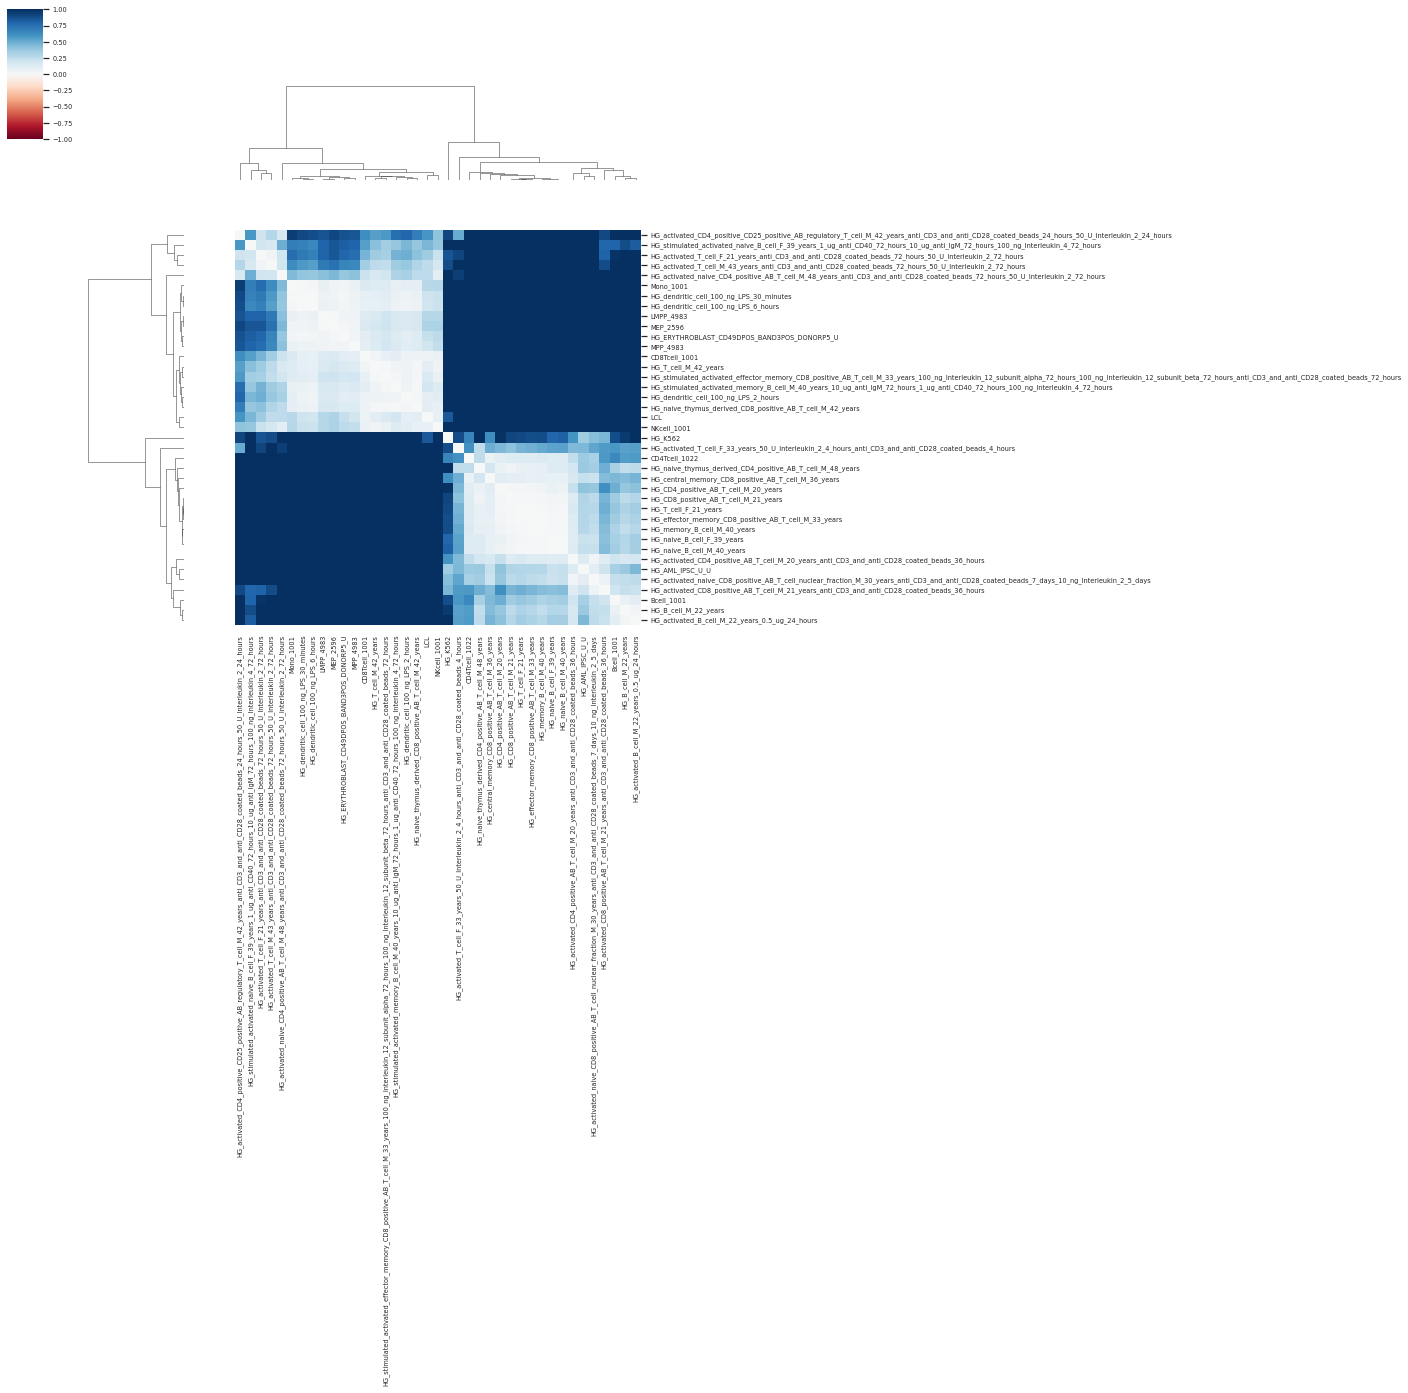

In [136]:
plt.figure(figsize=(15,10))
correlations = pd.DataFrame(pairwise_distances(df.T,metric='cosine'))
correlations.index=index
correlations.columns=index
sns.set(font_scale=0.6)
sns.clustermap(correlations, cmap='RdBu', vmin=-1, vmax=1)

In [135]:
df

,Bcell_1001,CD4Tcell_1022,CD8Tcell_1001,HG_AML_IPSC_U_U,HG_B_cell_M_22_years,HG_CD4_positive_AB_T_cell_M_20_years,HG_CD8_positive_AB_T_cell_M_21_years,HG_ERYTHROBLAST_CD49DPOS_BAND3POS_DONORP5_U,HG_K562,HG_T_cell_F_21_years,...,HG_naive_thymus_derived_CD8_positive_AB_T_cell_M_42_years,HG_stimulated_activated_effector_memory_CD8_positive_AB_T_cell_M_33_years_100_ng_Interleukin_12_subunit_alpha_72_hours_100_ng_Interleukin_12_subunit_beta_72_hours_anti_CD3_and_anti_CD28_coated_beads_72_hours,HG_stimulated_activated_memory_B_cell_M_40_years_10_ug_anti_IgM_72_hours_1_ug_anti_CD40_72_hours_100_ng_Interleukin_4_72_hours,HG_stimulated_activated_naive_B_cell_F_39_years_1_ug_anti_CD40_72_hours_10_ug_anti_IgM_72_hours_100_ng_Interleukin_4_72_hours,LCL,LMPP_4983,MEP_2596,MPP_4983,Mono_1001,NKcell_1001
0,0.255902,0.986831,-0.728360,0.704427,0.355574,1.202787,1.053279,-1.222567,0.214372,1.435355,...,-1.058524,-0.886174,-1.308742,-0.267376,-0.786502,-1.087595,-1.232950,-0.973387,-1.487840,-0.450108
1,-0.266723,-0.857356,0.570006,-0.562040,-0.303638,-1.349550,-1.054234,0.902237,0.182404,-1.731000,...,1.019133,1.048357,1.322140,0.317757,0.665369,0.989909,1.197553,1.076043,1.365207,0.496177
2,-0.272501,-0.814150,0.862161,-0.851505,-0.421921,-1.075636,-1.038281,1.221704,-0.225807,-1.411832,...,1.020920,0.773443,1.263729,0.175761,0.810798,1.291745,1.417818,1.058275,1.613933,0.427908
3,0.238114,0.994628,-0.705405,0.790624,0.323115,1.198632,1.045629,-1.209039,0.272114,1.436637,...,-1.070912,-0.905159,-1.345042,-0.280396,-0.756406,-1.109162,-1.251540,-0.981660,-1.525670,-0.441900
4,-0.451524,-0.435722,0.749433,-0.498930,-0.672753,-1.257429,-1.146815,1.276827,0.306975,-1.541866,...,0.919305,0.824493,1.132633,-0.198691,0.800790,1.328184,1.520771,1.343986,1.471390,0.520303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,-0.502009,-0.805009,1.496186,-1.411009,-0.630554,-0.694827,-1.052918,0.891333,-0.814191,-1.337555,...,0.914288,1.315992,0.886742,0.475856,0.804106,0.991185,0.576856,0.406992,0.521765,1.037095
380,-0.363365,-0.542088,0.701526,-0.959109,-0.497408,-1.108044,-1.018683,1.323333,-0.184642,-1.435703,...,0.962164,0.790887,1.260035,0.068549,0.731313,1.278652,1.472269,1.263759,1.736630,0.336633
381,0.248385,0.973194,-0.701364,0.756584,0.356690,1.173141,1.039843,-1.222060,0.265048,1.423075,...,-1.072099,-0.897146,-1.365772,-0.243152,-0.726357,-1.097093,-1.259550,-0.997119,-1.559471,-0.443099
382,-0.371192,-0.836248,0.614283,-1.168430,-0.382265,-1.057703,-0.969121,1.361693,-0.747666,-1.279158,...,1.084874,0.885565,1.588685,0.104936,0.614283,1.023974,1.361693,0.896638,2.094138,0.370682


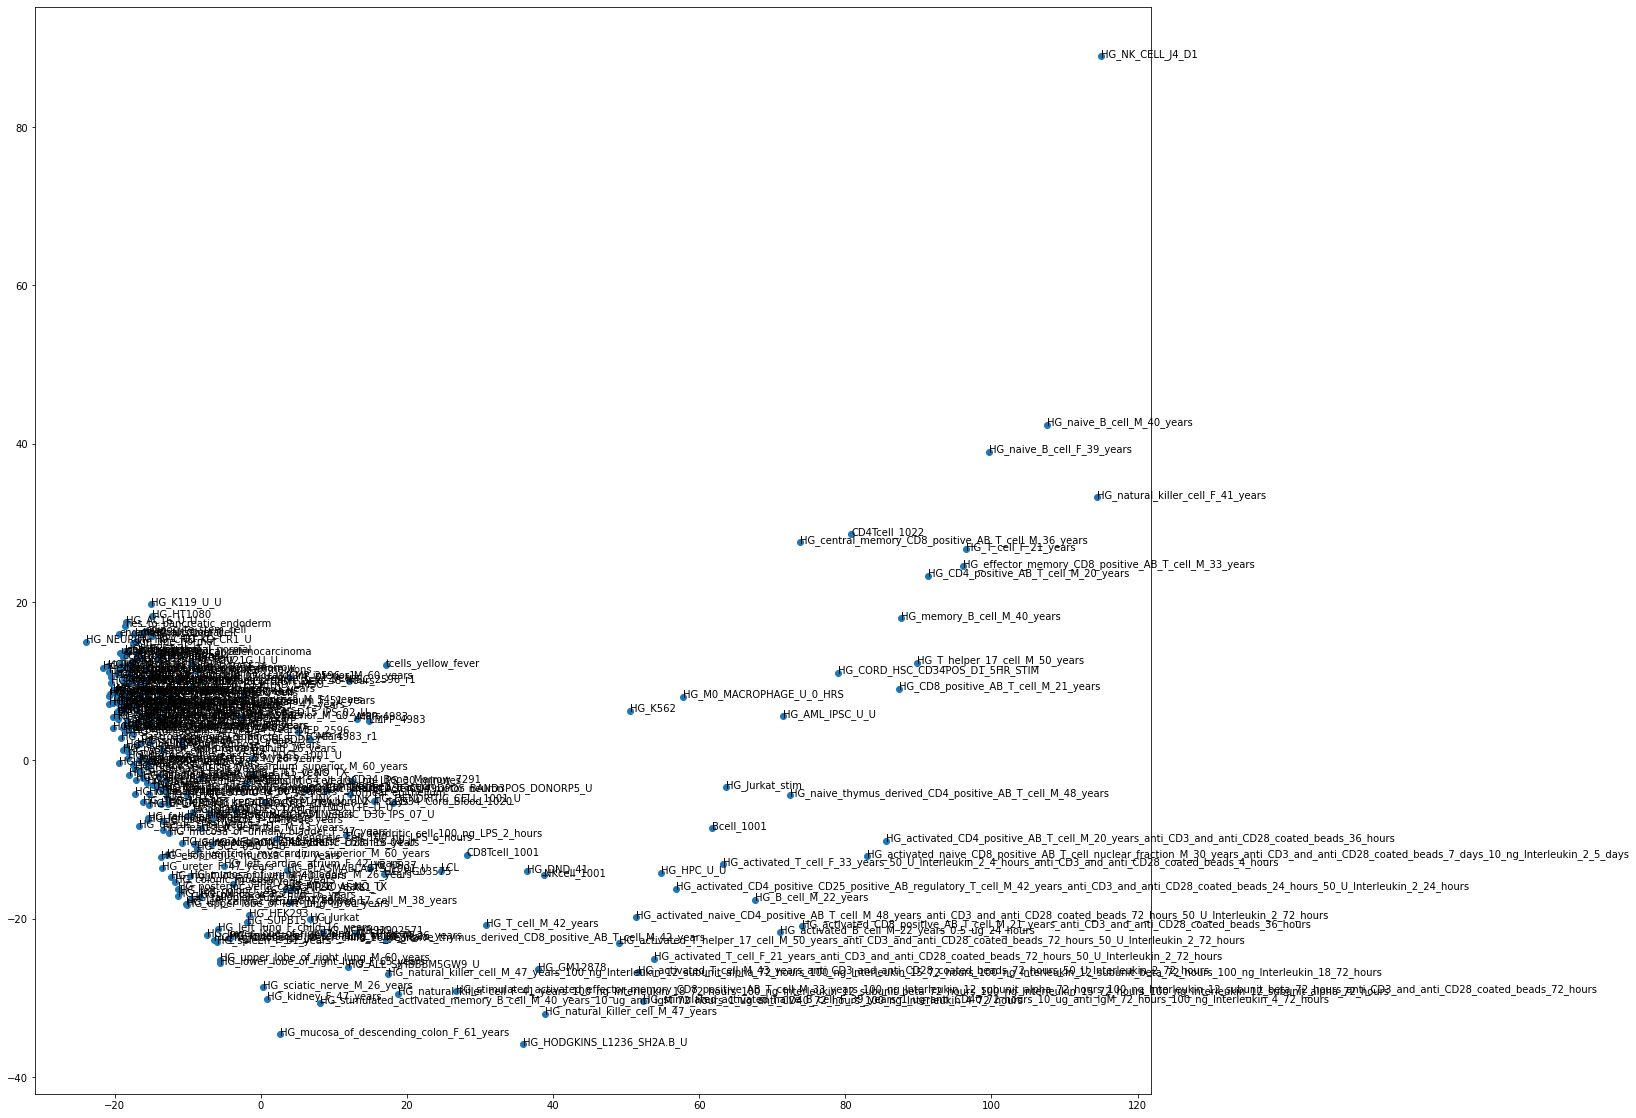

In [52]:
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

plt.rcParams["figure.figsize"] = (20,20)
pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(att_out_all_np)
plt.scatter(Xt[:,0], Xt[:,1])
#plt.legend(handles=plot.legend_elements()[0])
for i, txt in enumerate(file_names_all):
    plt.annotate(txt, (Xt[i,0], Xt[i,1]))
    
plt.show()

In [35]:
file_names_all

['22rv1_prostatic_cancer',
 '2cell_3pn_preimplant',
 '4cell_3pn_preimplant',
 '6tfs_epithelial',
 '8cell_3pn_preimplant',
 '8cell_preimplant',
 'BE2C_cells',
 'BIN_67_ovarian',
 'Bcell_1001',
 'C15_cell_line',
 'CD34_Bone_Marrow_7291',
 'CD34_Cord_Blood_1020',
 'CD4Tcell_1022',
 'CD8Tcell_1001',
 'CLP_2596_r1',
 'CMP_2596_r1',
 'CRL7250_fibroblast',
 'Ery_2596',
 'FT190_ovarian',
 'GMP_2596',
 'GMP_4983_r1',
 'H1703',
 'HAP1',
 'HESC',
 'HG_A549',
 'HG_AC16_U_U',
 'HG_ALL_SJHBBBM5GW9_U',
 'HG_AML_IPSC_U_U',
 'HG_ATAC_IN_27_U_U',
 'HG_ATL10_U_NO_TX',
 'HG_BJ_U_DEEP_SENESCENCE',
 'HG_B_cell_M_22_years',
 'HG_CASKI_U_U',
 'HG_CD4_positive_AB_T_cell_M_20_years',
 'HG_CD8_positive_AB_T_cell_M_21_years',
 'HG_CORD_HSC_CD34POS_D1_5HR_STIM',
 'HG_CTL5_U_NO_TX',
 'HG_DENDRITIC_CELL_1001_U',
 'HG_DND_41',
 'HG_EMBROYO_2CELL_3PN_U_U',
 'HG_EPIDERMAL_KERATINOCYTE_CTLI_U',
 'HG_ERYTHROBLAST_CD49DPOS_BAND3POS_DONORP5_U',
 'HG_GM12878',
 'HG_GM23338',
 'HG_H1',
 'HG_H9_U_D28',
 'HG_HC1_IPSC_U_D22',
 

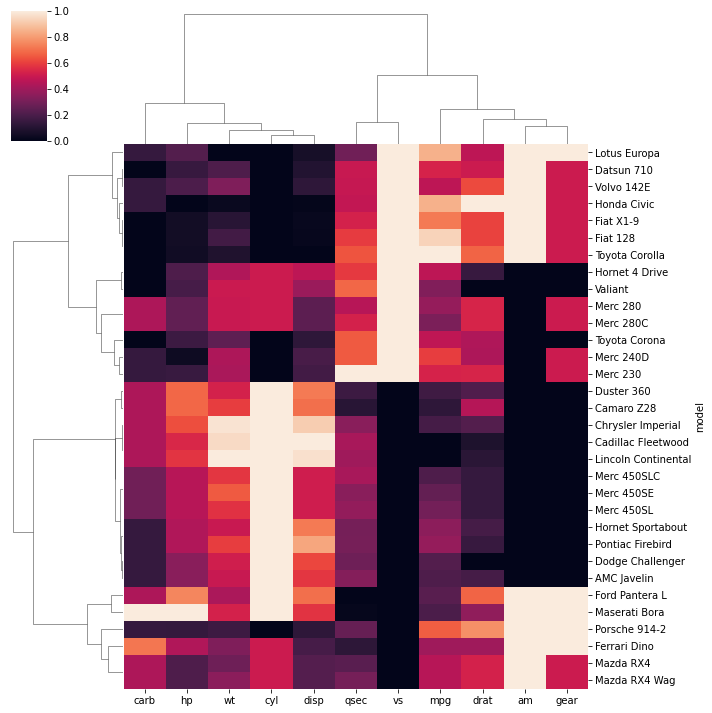

In [57]:
# Libraries
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
 
# Data set
url = 'https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/mtcars.csv'
df = pd.read_csv(url)
df = df.set_index('model') 
 
# plot with correlation distance
sns.clustermap(df, metric="correlation", standard_scale=1)

In [58]:
df

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
model,,,,,,,,,,,
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2


In [ ]:
s